In [1]:
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
absolute_path = '/Users/aygalic/OneDrive/polimi/Thesis/data/quant/'

# Exploring the Dataset

In [3]:
# getting entries ready
# each couple of entries correspond to one patient

entries = os.listdir(absolute_path)
entries_transcripts = [e for e in entries if "transcripts" in e ]

# Building a TensorFlow input pipeline

## We want to build a tf.Dataset from this

In [6]:
# from filename to tensor

def load_patient_data(filename):
  #specify read types for our data
  read_types = [float()]
  # get a first sample to base everything of
  text = pathlib.Path(absolute_path + filename).read_text()
  lines = text.split('\n')[1:-1]
  features = tf.io.decode_csv(lines, record_defaults=read_types, field_delim = "\t", select_cols=[3]) 
  data = tf.convert_to_tensor(features)[0]
  return data

# Feed it into a net

In [7]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras

# now we build a tf.dataset with all patients inside


## Load all the data


In [8]:
# load the dataset into a list using the first pipeline

train_ds = [load_patient_data(e) for e in entries_transcripts]
train_ds = [e for e in train_ds if e.shape == (95309)] 

## process it

In [10]:
import scipy



In [51]:
data_array = np.array(train_ds)
MAD = scipy.stats.median_abs_deviation(data_array)
gene_selected = [True if val > 5 else False for val in MAD]
data_selected = data_array[:,gene_selected]

In [52]:
p = sum(gene_selected)
p

6065

In [53]:
data_selected = data_array[:,gene_selected]

In [54]:
data_selected.shape

(4755, 6065)

In [55]:
batch_size = 64

# turn it into a tf.data.Dataset object
x_train = tf.data.Dataset.from_tensor_slices(data_selected)

dataset = x_train.batch(batch_size)


# train it

In [57]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [58]:
latent_dim = 64

t_shape = (p)
encoder_inputs = keras.Input(shape=t_shape)
x = layers.Flatten()(encoder_inputs)
x = layers.UnitNormalization()(x) # to avoid overloading float32
x = layers.Dense(256, activation = "ELU")(x)
x = layers.Dense(128, activation = "ELU")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation = "ELU")(x)
x = layers.Dense(64, activation = "ELU")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6065)]       0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 6065)         0           ['input_9[0][0]']                
                                                                                                  
 unit_normalization_4 (UnitNorm  (None, 6065)        0           ['flatten_4[0][0]']              
 alization)                                                                                       
                                                                                                  
 dense_32 (Dense)               (None, 256)          1552896     ['unit_normalization_4[0][0

In [59]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="ELU")(latent_inputs)
x = layers.Dense(128, activation="ELU")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="ELU")(latent_inputs)
x = layers.Dense(256, activation="ELU")(latent_inputs)
decoder_outputs = layers.Dense(p, activation="ELU")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_39 (Dense)            (None, 256)               16640     
                                                                 
 dense_40 (Dense)            (None, 6065)              1558705   
                                                                 
Total params: 1,575,345
Trainable params: 1,575,345
Non-trainable params: 0
_________________________________________________________________


In [60]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(0)
                )
            #reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction) # which one is right ???
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [61]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [62]:
hist = vae.fit(dataset, epochs=2000) # do 1K



Epoch 1/2000
75/75 [==============================] - 2s 15ms/step - loss: 1231749.9967 - reconstruction_loss: 1121175.6250 - kl_loss: 16509.4805
Epoch 2/2000
75/75 [==============================] - 1s 15ms/step - loss: 967420.6184 - reconstruction_loss: 784884.9375 - kl_loss: 52486.9961
Epoch 3/2000
75/75 [==============================] - 1s 15ms/step - loss: 654422.6036 - reconstruction_loss: 500307.0938 - kl_loss: 62852.7461
Epoch 4/2000
75/75 [==============================] - 1s 15ms/step - loss: 476949.8980 - reconstruction_loss: 393079.5000 - kl_loss: 51177.6719
Epoch 5/2000
75/75 [==============================] - 1s 15ms/step - loss: 431510.1003 - reconstruction_loss: 372715.0625 - kl_loss: 39337.8164
Epoch 6/2000
75/75 [==============================] - 1s 15ms/step - loss: 412662.1114 - reconstruction_loss: 365460.9688 - kl_loss: 31370.8691
Epoch 7/2000
75/75 [==============================] - 1s 16ms/step - loss: 402509.6739 - reconstruction_loss: 362238.4688 - kl_loss: 2

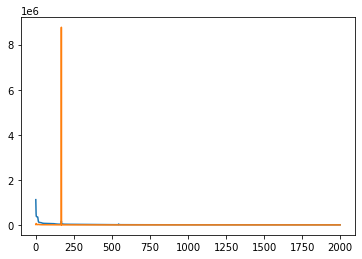

In [64]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])







In [65]:
#autoencoder.save('../workfiles/placeholder_model')
vae.encoder.save('../workfiles/vae_model_complex')



INFO:tensorflow:Assets written to: ../workfiles/vae_model_complex/assets


INFO:tensorflow:Assets written to: ../workfiles/vae_model_complex/assets
